
## 1) Environment Setup
Installs minimal dependencies if missing. Uses AMP and saves artifacts under `/kaggle/working/violence_detection/`.


In [1]:
!pip install -qqq timm onnx onnxruntime transformers datasets huggingface_hub safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
from datetime import datetime, timedelta
import sys, subprocess
import os, json, math, time, glob, hashlib
from transformers import MobileViTForImageClassification
from pathlib import Path
import math, random, gc, cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from tqdm.notebook import tqdm
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import time
import timm
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
from collections import Counter
import onnx, onnxruntime as ort
import seaborn as sns
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

BASE_DIR = '/kaggle/working/result/'
BASE = Path(BASE_DIR)
FRAMES_DIR = BASE / 'frames'
MODELS_DIR = BASE / 'models'
WEIGHTS_DIR = MODELS_DIR / 'weights'
REPORTS_DIR = BASE / 'reports'
INDEX_JSON = BASE / 'video_index.json'
for d in [FRAMES_DIR, WEIGHTS_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(datetime.utcnow() + timedelta(hours=7))

2025-11-12 07:45:31.119483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762933531.326140      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762933531.390334      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

2025-11-12 14:45:55.742456



## 2) Configuration
- Input size: **224×224**
- Frames per second extracted: **20**
- Epochs: **30**
- Mixed precision: **True**
- Temporal smoothing: **EMA** over per-frame probabilities
- Anti-overfitting: **weight decay**, **dropout**, **label smoothing**, **strong augmentations**, **early stopping**, **gradient clipping**


In [3]:
@dataclass
class Config:
    # Model chọn: "apple/mobilevit-small" (Apple MobileViT-S) hoặc "vit_tiny_patch16_224.augreg_in21k_ft_in1k" (ViT-Tiny)
    MODEL_NAME: str = "apple/mobilevit-small"
    input_size: int = 256             # 256 cho MobileViT-S; đổi 224 nếu dùng ViT-Tiny
    # Extraction
    frames_per_second: int = 15       # FPS
    num_classes: int = 3
    # Train
    epochs: int = 30
    batch_size: int = 64
    lr: float = 1e-4
    weight_decay: float = 0.05
    label_smoothing: float = 0.1
    num_workers: int = os.cpu_count()//2
    amp: bool = True
    early_stopping_patience: int = 5
    grad_clip_norm: float = 1.0
    seed: int = 42
    ema_alpha: float = 0.3 # hệ số EMA cho suy luận real-time (0–1), 0.3–0.6 thường tốt
CFG = Config()
print(CFG)
print(datetime.utcnow() + timedelta(hours=7))

Config(MODEL_NAME='apple/mobilevit-small', input_size=256, frames_per_second=15, num_classes=3, epochs=1, batch_size=64, lr=0.0001, weight_decay=0.05, label_smoothing=0.1, num_workers=2, amp=True, early_stopping_patience=5, grad_clip_norm=1.0, seed=42, ema_alpha=0.3)
2025-11-12 14:45:55.852086



## 3) Dataset Indexing & Label Mapping
Parses all three datasets and builds an index of videos with labels and splits. AIRTLab maps **both** `violent/` and `non-violent/` to `PseudoViolence` by request.


In [4]:
random.seed(CFG.seed)

# Label mapping
LABELS = {
    'Violence': 0,
    'NonViolence': 1,
    'PseudoViolence': 2,
}
def vid_hash(path: str) -> str: 
    return hashlib.md5(path.encode()).hexdigest()[:12]
# Paths (Kaggle inputs)
PATH_HOCKEY = '/kaggle/input/hockey-fight-vidoes/data'
PATH_RWF = '/kaggle/input/rwf2000/RWF-2000'
PATH_AIRTLAB = '/kaggle/input/airtlab/violence-detection-dataset'

# ==== TỈ LỆ CHIA ====
TRAIN_RATIO = 0.75
VAL_RATIO   = 0.23
TEST_RATIO  = 0.02

# ==== KHỞI TẠO INDEX ====
index = {"train": [], "val": [], "test": []}

# ==== 1) RWF-2000: dùng split sẵn có (train/val) ====
rwf_train, rwf_val, rwf_test = [], [], []
for split in ['train', 'val']:
    for cls in ['Fight', 'NonFight']:
        folder = os.path.join(PATH_RWF, split, cls)
        if not os.path.isdir(folder): 
            continue
        for fn in sorted(os.listdir(folder)):
            if not fn.lower().endswith('.avi'):
                continue
            label = 'Violence' if cls == 'Fight' else 'NonViolence'
            item = {
                'path': os.path.join(folder, fn),
                'label': label,
                'source': 'RWF-2000'
            }
            if split == 'train':
                rwf_train.append(item)
            else:
                rwf_val.append(item)

print(f"[RWF] train={len(rwf_train)}, val={len(rwf_val)}")

rwf_take_test = int(0.02 * len(rwf_val))
random.seed(CFG.seed)
random.shuffle(rwf_val)
rwf_test = rwf_val[:rwf_take_test]
rwf_val  = rwf_val[rwf_take_test:]
print(f"[RWF] after carve -> val={len(rwf_val)}, test={len(rwf_test)}")

# ==== 2) Hockey: tạo split theo 85/13/2 ====
hockey_videos = []
if os.path.isdir(PATH_HOCKEY):
    for fn in sorted(os.listdir(PATH_HOCKEY)):
        if not fn.lower().endswith('.avi'):
            continue
        lower = fn.lower()
        if 'fi' in lower:
            label = 'Violence'
        elif 'no' in lower:
            label = 'NonViolence'
        else:
            # không khớp quy tắc tên, bỏ qua
            continue
        hockey_videos.append({
            'path': os.path.join(PATH_HOCKEY, fn),
            'label': label,
            'source': 'Hockey'
        })

random.seed(CFG.seed)
random.shuffle(hockey_videos)

n = len(hockey_videos)
n_train = int(n * TRAIN_RATIO)
n_val   = int(n * VAL_RATIO)
n_test  = n - n_train - n_val

h_train = hockey_videos[:n_train]
h_val   = hockey_videos[n_train:n_train+n_val]
h_test  = hockey_videos[n_train+n_val:n_train+n_val+n_test]

print(f"[Hockey] total={n} -> train={len(h_train)}, val={len(h_val)}, test={len(h_test)}")

# ==== 3) AIRTLab: map violent & non-violent => PseudoViolence và chia 85/13/2 ====

air_videos = []
for sub in ['non-violent', 'violent']:
    subdir = os.path.join(PATH_AIRTLAB, sub)
    if not os.path.isdir(subdir): 
        continue
    for cam in ['cam1', 'cam2']:
        camdir = os.path.join(subdir, cam)
        if not os.path.isdir(camdir):
            continue
        for fn in sorted(os.listdir(camdir)):
            lower = fn.lower()
            if not (lower.endswith('.mp4') or lower.endswith('.avi') or lower.endswith('.mov')):
                continue
            air_videos.append({
                'path': os.path.join(camdir, fn),
                'label': 'PseudoViolence',   # theo yêu cầu: cả violent & non-violent -> Pseudo
                'source': 'AIRTLab'
            })

random.seed(CFG.seed)
random.shuffle(air_videos)

na = len(air_videos)
na_train = int(na * TRAIN_RATIO)
na_val   = int(na * VAL_RATIO)
na_test  = na - na_train - na_val

a_train = air_videos[:na_train]
a_val   = air_videos[na_train:na_train+na_val]
a_test  = air_videos[na_train+na_val:na_train+na_val+na_test]

print(f"[AIRTLab] total={na} -> train={len(a_train)}, val={len(a_val)}, test={len(a_test)}")

print(datetime.utcnow() + timedelta(hours=7))

[RWF] train=1600, val=400
[RWF] after carve -> val=392, test=8
[Hockey] total=1000 -> train=850, val=130, test=20
[AIRTLab] total=350 -> train=297, val=45, test=8
2025-11-12 14:45:56.291763


## Thống kê cuối & lưu

In [5]:
index = {"train": [], "val": [], "test": []}

# Gộp các nguồn
index['train'] += h_train + rwf_train + a_train
index['val']   += h_val   + rwf_val   + a_val
index['test']  += h_test  + rwf_test  + a_test

# Sanity check: không có video lặp giữa các split
def paths_set(items): return set(it['path'] for it in items)
train_set = paths_set(index['train'])
val_set   = paths_set(index['val'])
test_set  = paths_set(index['test'])

inter_tv  = train_set & val_set
inter_tt  = train_set & test_set
inter_vt  = val_set & test_set
assert len(inter_tv) == 0 and len(inter_tt) == 0 and len(inter_vt) == 0, \
    f"Leak found! train∩val={len(inter_tv)}, train∩test={len(inter_tt)}, val∩test={len(inter_vt)}"

# Ghi file index
with open(INDEX_JSON, 'w') as f:
    json.dump(index, f, indent=2)

# Thống kê phân bố lớp theo split
for split in ['train','val','test']:
    labels = [it['label'] for it in index.get(split,[])]
    print(f"{split}: total={len(labels)} | dist={Counter(labels)}")

print(f"Saved index to {INDEX_JSON}")
print(datetime.utcnow() + timedelta(hours=7))

train: total=2747 | dist=Counter({'NonViolence': 1225, 'Violence': 1225, 'PseudoViolence': 297})
val: total=567 | dist=Counter({'NonViolence': 264, 'Violence': 258, 'PseudoViolence': 45})
test: total=36 | dist=Counter({'Violence': 17, 'NonViolence': 11, 'PseudoViolence': 8})
Saved index to /kaggle/working/result/video_index.json
2025-11-12 14:45:56.422430



## 4) Frame Extraction (20 FPS)
For each video, we extract **20 frames per second**. Robust to varying FPS: selects evenly-spaced frames using timestamps.
Frames are saved to `BASE_DIR/frames/<split>/<label>/<video_id>/frame_XXXX.jpg`.


In [6]:
def letterbox_resize_bgr(frame_bgr, target_w, target_h, pad_color=(0,0,0)):
    h, w = frame_bgr.shape[:2]
    scale = min(target_w / w, target_h / h)
    nw, nh = int(w * scale), int(h * scale)
    resized = cv2.resize(frame_bgr, (nw, nh), interpolation=cv2.INTER_AREA)
    top = (target_h - nh) // 2
    bottom = target_h - nh - top
    left = (target_w - nw) // 2
    right = target_w - nw - left
    out = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_color)
    return out

def extract_resized(video_path, out_dir, target_size, jpeg_quality, overwrite, target_fps):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        tqdm.write(f"[WARN] Cannot open: {video_path}")
        return 0

    fps = cap.get(cv2.CAP_PROP_FPS)
    if not fps or fps <= 0: fps = 30.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    step_t = 1.0 / float(target_fps)
    next_t = 0.0
    idx = 0
    saved = 0

    # progress per video (ước lượng theo số khung cần trích)
    expected = int(duration * target_fps)
    while True:
        ok, frame = cap.read()
        if not ok: break
        t = idx / fps
        if t + 1e-6 >= next_t:
            canvas = letterbox_resize_bgr(frame, target_size[0], target_size[1], pad_color=(0,0,0))
            
            fn_orig = out_dir / f"frame_{saved:06d}.jpg"
            if overwrite or (not fn_orig.exists()):
                cv2.imwrite(str(fn_orig), canvas, [cv2.IMWRITE_JPEG_QUALITY, int(jpeg_quality)])
            
            flipped = cv2.flip(canvas, 1)
            fn_flip = out_dir / f"frame_{saved:06d}_flip.jpg"
            if overwrite or (not fn_flip.exists()):
                cv2.imwrite(str(fn_flip), flipped, [cv2.IMWRITE_JPEG_QUALITY, int(jpeg_quality)])

            saved += 1
            next_t += step_t
        idx += 1
        if t > duration + 1.0: break

    cap.release()
    return saved, saved

with open(INDEX_JSON, 'r') as f:
    index = json.load(f)

for split, items in index.items():
    print(f"Split: {split}, videos: {len(items)}")
    print(datetime.utcnow() + timedelta(hours=7))
    for it in tqdm(items, desc=f"{split} videos", leave=False):
        label = it['label']
        vid = it['path']
        vhid = vid_hash(vid)
        out_dir = Path(FRAMES_DIR) / split / label / vhid
        n_orig, n_flip = extract_resized(vid, out_dir, target_size=(CFG.input_size, CFG.input_size), jpeg_quality=85, overwrite=False, target_fps=CFG.frames_per_second)

print("Frame extraction done.")
print(datetime.utcnow() + timedelta(hours=7))

Split: train, videos: 2747
2025-11-12 14:45:56.564638


train videos:   0%|          | 0/2747 [00:00<?, ?it/s]

Split: val, videos: 567
2025-11-12 15:04:50.462299


val videos:   0%|          | 0/567 [00:00<?, ?it/s]

Split: test, videos: 36
2025-11-12 15:10:05.454511


test videos:   0%|          | 0/36 [00:00<?, ?it/s]

Frame extraction done.
2025-11-12 15:10:18.489499



## 5) PyTorch Dataset & Augmentations
Loads extracted frames with strong real-time-friendly augmentations and returns tensors sized 224×224.


In [7]:
train_tfms = T.Compose([
    T.Resize((CFG.input_size, CFG.input_size)),
    T.RandomResizedCrop(CFG.input_size, scale=(0.7, 1.0), ratio=(0.8, 1.25)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.Resize((CFG.input_size, CFG.input_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class FrameFolderDataset(Dataset):
    def __init__(self, split, transforms=None):
        self.items = []
        base = os.path.join(FRAMES_DIR, split)
        for label_name in LABELS.keys():
            labdir = os.path.join(base, label_name)
            if not os.path.isdir(labdir): continue
            for vid_folder in sorted(os.listdir(labdir)):
                full = os.path.join(labdir, vid_folder)
                if not os.path.isdir(full): continue
                frames = sorted(glob.glob(os.path.join(full, '*.jpg')))
                for fr in frames:
                    self.items.append((fr, LABELS[label_name]))
        self.transforms = transforms
        print(f"Loaded {len(self.items)} frames in split={split}")

    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        p, y = self.items[idx]
        img = Image.open(p).convert('RGB')
        if self.transforms: img = self.transforms(img)
        return img, y

train_loader = DataLoader(FrameFolderDataset('train', transforms=train_tfms), batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
val_loader   = DataLoader(FrameFolderDataset('val',   transforms=val_tfms),   batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
test_loader  = val_loader
print(datetime.utcnow() + timedelta(hours=7))

Loaded 332748 frames in split=train
Loaded 73188 frames in split=val
2025-11-12 15:10:19.578968


## 6) Model: ViT-Tiny (timm) with 3-way classifier
- Lightweight ViT backbone (`vit_tiny_patch16_224`) for speed.
- Dropout, label smoothing, cosine LR with warmup.
- AMP training + gradient clipping.


In [8]:
def build_model(model_name, num_classes):
    # Tạo model timm & đặt đúng số lớp
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=num_classes
    )
    return model

def build_model_hf_mobilevit(model_name, num_classes):
    model = MobileViTForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    return model

# model = build_model(CFG.MODEL_NAME, CFG.num_classes)
model = build_model_hf_mobilevit(CFG.MODEL_NAME, CFG.num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

steps_per_epoch = max(1, len(train_loader))
total_steps = steps_per_epoch * CFG.epochs
warmup_steps = int(0.1 * total_steps)

class CosineWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        super().__init__(optimizer, last_epoch)
    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []
        for base_lr in self.base_lrs:
            if step < self.warmup_steps:
                lr = base_lr * step / max(1, self.warmup_steps)
            else:
                progress = (step - self.warmup_steps) / max(1, self.total_steps - self.warmup_steps)
                lr = base_lr * 0.5 * (1 + math.cos(math.pi * progress))
            lrs.append(lr)
        return lrs

scheduler = CosineWithWarmup(optimizer, warmup_steps=warmup_steps, total_steps=total_steps)
scaler = torch.amp.GradScaler('cuda', enabled=CFG.amp)
print(datetime.utcnow() + timedelta(hours=7))

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([3, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

2025-11-12 15:10:21.889565



## 7) Training Loop (AMP) + Logging
Saves:
- `models/weights/vit_tiny_best.pth`
- `training_history.pkl`
- `loss.png`, `accuracy.png`


Training epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1 [train]:   0%|          | 0/5200 [00:00<?, ?it/s]

Epoch 1 [val]:   0%|          | 0/1144 [00:00<?, ?it/s]

Epoch 1/1 | Train Loss 0.4199 Acc 0.9268 | Val Loss 0.8986 Acc 0.7645
2025-11-12 15:46:32.586579


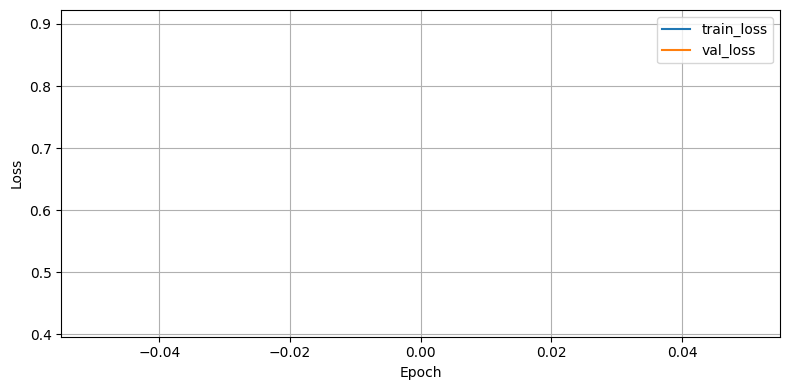

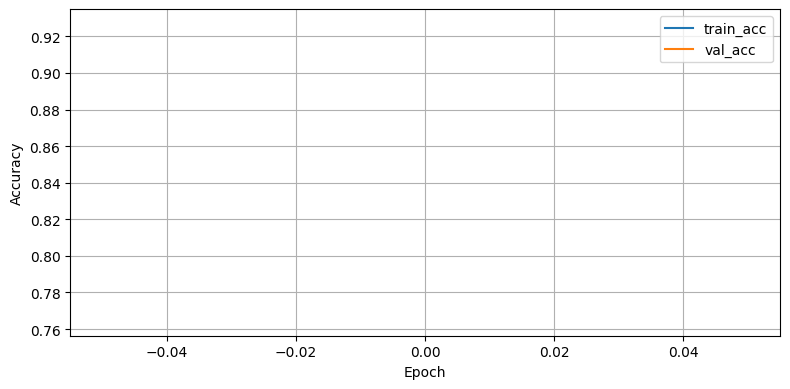

Training finished.
2025-11-12 15:46:43.217991


In [9]:
best_val_acc, patience, no_improve = 0.0, CFG.early_stopping_patience, 0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

def get_logits(m, x):
    out = m(x)
    return out.logits if hasattr(out, "logits") else out  # hỗ trợ transformers & timm
def safe_name(name: str) -> str:
    """Sanitize a model name to be safe for filenames."""
    return (
        name.replace('/', '__')
            .replace('\\', '__')
            .replace(':', '-')
            .replace(' ', '_')
    )

for epoch in tqdm(range(1, CFG.epochs+1), desc="Training epochs"):
    # ===== Train =====
    model.train()
    train_losses, train_preds, train_targets = [], [], []

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{CFG.epochs} [train]", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=CFG.amp):
            logits = get_logits(model, imgs)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.grad_clip_norm)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_losses.append(loss.item())
        train_preds.extend(torch.argmax(logits, dim=1).detach().cpu().numpy().tolist())
        train_targets.extend(targets.detach().cpu().numpy().tolist())
    train_acc = accuracy_score(train_targets, train_preds)
    history['train_loss'].append(float(np.mean(train_losses)))
    history['train_acc'].append(float(train_acc))

    # ===== Val =====
    model.eval()
    val_losses, val_preds, val_targets = [], [], []
    with torch.no_grad():
        for imgs, targets in tqdm(val_loader, desc=f"Epoch {epoch} [val]", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True).long()
            with torch.amp.autocast('cuda', enabled=CFG.amp):
                logits = get_logits(model, imgs)
                loss = criterion(logits, targets)
            val_losses.append(loss.item())
            val_preds.extend(torch.argmax(logits, dim=1).detach().cpu().numpy().tolist())
            val_targets.extend(targets.detach().cpu().numpy().tolist())

    val_acc = accuracy_score(val_targets, val_preds)
    history['val_loss'].append(float(np.mean(val_losses)))
    history['val_acc'].append(float(val_acc))

    print(f"Epoch {epoch}/{CFG.epochs} | Train Loss {history['train_loss'][-1]:.4f} Acc {train_acc:.4f} | Val Loss {history['val_loss'][-1]:.4f} Acc {val_acc:.4f}")
    print(datetime.utcnow() + timedelta(hours=7))

    # Early stopping + save best
    if val_acc > best_val_acc:
        best_val_acc, no_improve = val_acc, 0        
        best_fname = f"{safe_name(CFG.MODEL_NAME)}_best.pth"
        best_path = WEIGHTS_DIR / best_fname
        torch.save(model.state_dict(), str(best_path))
    else:
        no_improve += 1
        if no_improve >= patience:
            print('Early stopping triggered.')
            break

# Save history & plots
with open(os.path.join(BASE_DIR, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history, f)

plt.figure(figsize=(8,4))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(BASE_DIR, 'loss.png')); plt.show()

plt.figure(figsize=(8,4))
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(BASE_DIR, 'accuracy.png')); plt.show()

print("Training finished.")
print(datetime.utcnow() + timedelta(hours=7))


## 8) Evaluation & Reports
Generates `classification_report.txt` and confusion matrix plot.


2025-11-12 15:46:43.331940


Evaluate [test]:   0%|          | 0/1144 [00:00<?, ?it/s]

                precision    recall  f1-score   support

      Violence     0.7739    0.6615    0.7133     32416
   NonViolence     0.7082    0.8096    0.7555     32898
PseudoViolence     1.0000    1.0000    1.0000      7874

      accuracy                         0.7645     73188
     macro avg     0.8274    0.8237    0.8229     73188
  weighted avg     0.7687    0.7645    0.7631     73188



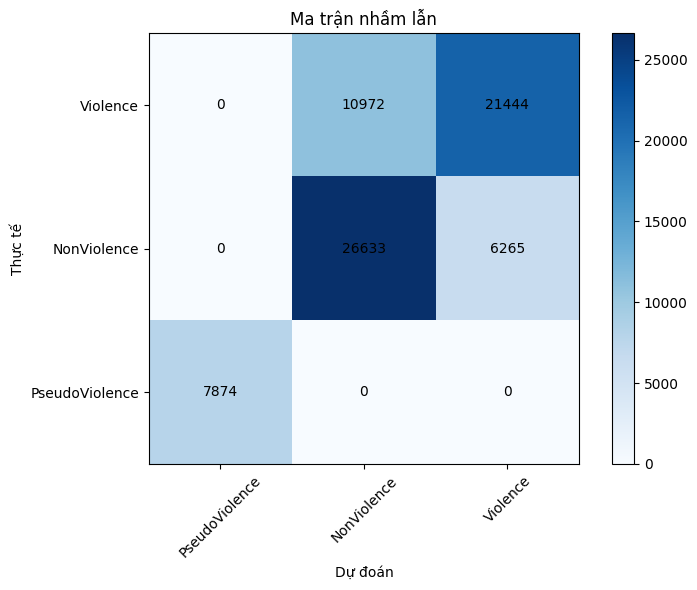

Evaluation finished.
2025-11-12 15:48:52.352041


In [10]:
print(datetime.utcnow() + timedelta(hours=7))

def forward_logits(m, x):
    out = m(x)
    if hasattr(out, "logits"):     # Transformers
        return out.logits
    if isinstance(out, dict) and "logits" in out:
        return out["logits"]
    return out

best_w = WEIGHTS_DIR / f"{safe_name(CFG.MODEL_NAME)}_best.pth"
if best_w.exists():
    model.load_state_dict(torch.load(str(best_w), map_location=device))
else:
    raise FileNotFoundError(f"Best weights not found: {best_w}")
model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Evaluate [test]"):
        imgs = imgs.to(device)        
        with torch.amp.autocast('cuda', enabled=CFG.amp):
            logits = forward_logits(model, imgs)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.numpy().tolist())

rep = classification_report(all_targets, all_preds, target_names=list(LABELS.keys()), digits=4)
print(rep)
with open(os.path.join(BASE_DIR, 'classification_report.txt'), 'w') as f:
    f.write(rep)
CLASS_NAMES = list(LABELS.keys())  # ['Violence','NonViolence','PseudoViolence']
cm = confusion_matrix(all_targets, all_preds)
cm_mirrored = cm[:, ::-1]

plt.figure(figsize=(8,6))
plt.imshow(cm_mirrored, cmap='Blues')
plt.title('Ma trận nhầm lẫn')
plt.colorbar()

plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES[::-1], rotation=45)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)

for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        plt.text(j, i, cm_mirrored[i, j], ha='center', va='center', color='black')

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'confusion_matrix.png'))
plt.show()

print("Evaluation finished.")
print(datetime.utcnow() + timedelta(hours=7))


## 9) Export to ONNX & Quick CPU Inference (ONNX Runtime)
Exports the trained classifier and runs a quick inference timing test on a batch.


In [11]:
class LogitsOnly(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
    def forward(self, x):
        out = self.base(x)
        if hasattr(out, "logits"): return out.logits
        if isinstance(out, dict) and "logits" in out: return out["logits"]
        return out

export_model = LogitsOnly(model).eval()
onnx_path = WEIGHTS_DIR / f"{safe_name(CFG.MODEL_NAME)}_best.onnx"
dummy = torch.randn(1, 3, CFG.input_size, CFG.input_size, device=device)

torch.onnx.export(
    export_model, dummy, str(onnx_path),
    input_names=['input'], output_names=['logits'],
    opset_version=17, do_constant_folding=True,
    dynamic_axes={'input': {0: 'batch'}, 'logits': {0: 'batch'}}
)
print(f"Saved ONNX to {onnx_path}")

onnx_model = onnx.load(str(onnx_path))
onnx.checker.check_model(onnx_model)

sess = ort.InferenceSession(str(onnx_path), providers=['CPUExecutionProvider'])
input_name = sess.get_inputs()[0].name
batch = np.random.randn(32, 3, CFG.input_size, CFG.input_size).astype(np.float32)
start = time.time()
out = sess.run(None, {input_name: batch})[0]   # shape: [32, num_classes]
lat = (time.time() - start) * 1000.0
print(f"ONNXRuntime batch=32 latency: {lat:.2f} ms")

print(datetime.utcnow() + timedelta(hours=7))

/usr/local/lib/python3.11/dist-packages/transformers/models/mobilevit/modeling_mobilevit.py:435: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if new_width != orig_width or new_height != orig_height:


Saved ONNX to /kaggle/working/result/models/weights/apple__mobilevit-small_best.onnx
ONNXRuntime batch=32 latency: 3058.36 ms
2025-11-12 15:48:57.481005



## 10) Real-time Inference Pipeline (OpenCV)
Reads frames from camera/video, runs model, and applies **EMA smoothing** over per-frame probabilities to stabilize outputs.


In [12]:
infer_tfms = T.Compose([
    T.Resize((CFG.input_size, CFG.input_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

@torch.no_grad()
def infer_frame_bgr(bgr):
    img = Image.fromarray(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    ten = infer_tfms(img).unsqueeze(0).to(device, non_blocking=True)
    with torch.amp.autocast('cuda', enabled=CFG.amp):
        logits = forward_logits(model, ten)
        probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    return probs

# EMA smoothing over time
class ProbEMA:
    def __init__(self, alpha=CFG.ema_alpha, num_classes=CFG.num_classes):
        self.alpha = alpha
        self.state = np.zeros(num_classes, dtype=np.float32)
    def update(self, probs):
        self.state = self.alpha * probs + (1-self.alpha) * self.state
        return self.state

# Demo with a sample video (replace with 0 for webcam)
source = 0  # webcam; or provide a path to a video file
cap = cv2.VideoCapture(source)
ema = ProbEMA()

while True:
    ok, frame = cap.read()
    if not ok:
        break
    t0 = time.time()
    probs = infer_frame_bgr(frame)
    smoothed = ema.update(probs)
    pred =(np.argmax(smoothed))
    label = list(LABELS.keys())[pred]
    latency_ms = (time.time() - t0) * 1000.0

    # Overlay text
    cv2.putText(frame, f"Pred: {label} | latency: {latency_ms:.1f}ms", (10, 28),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, cv2.LINE_AA)
    cv2.imshow('Violence Detection (ViT)', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
#cv2.destroyAllWindows()

[ WARN:0@3787.082] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@3787.083] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range


error: OpenCV(4.12.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'



## 11) Notes on Real-time Optimizations Applied
- **AMP (Mixed Precision)** for faster GPU throughput.
- **ViT-Tiny** backbone for low latency.
- **ONNX export** + **ONNX Runtime** for CPU acceleration.
- **EMA temporal smoothing** to stabilize per-frame predictions.
- **Strong augmentations + label smoothing + weight decay + dropout** to combat overfitting.
- **Cosine LR with warmup**, **early stopping**, **gradient clipping** for stable training.
- **Pinned memory & non-blocking transfers** improve input pipeline speed.

> For multi-stream scalability (10–20 streams), run inference in separate threads/processes, use batched model calls, and share a single model on GPU; on CPU, prefer ONNX with `OpenVINO`/`TensorRT` if available.
